In [2]:
import os
from dotenv import load_dotenv
import logging
import pandas as pd
import numpy as np
from pymongo import MongoClient
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [3]:
# Logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [4]:
# Load env

load_dotenv()
MONGO_URI = os.environ.get("MONGO_URI")
DB_NAME = os.environ.get("DB_NAME")
MLFLOW_TRACKING_URI = os.environ.get("MLFLOW_TRACKING_URI")
MLFLOW_EXPERIMENT_NAME = os.environ.get("MLFLOW_EXPERIMENT_NAME")
RANDOM_STATE = int(os.environ.get("RANDOM_STATE"))

In [5]:
if not MONGO_URI or not DB_NAME:
    raise ValueError("MONGO_URI and DB_NAME must be set in .env")

In [6]:
#setting mlflow

import requests
def check_mlflow_server(uri):
    """Check if MLflow server is reachable."""
    try:
        resp = requests.get(f"{uri}/api/2.0/mlflow/experiments/list", timeout=3)
        return resp.status_code == 200
    except Exception:
        return False

if check_mlflow_server(MLFLOW_TRACKING_URI):
    tracking_uri = MLFLOW_TRACKING_URI
    logging.info(f" Connected to MLflow server at {MLFLOW_TRACKING_URI}")
else:
    # fallback to local file storage
    fallback_path = "file:///D:/fraud_detection/mlruns"
    tracking_uri = fallback_path
    logging.warning(f"⚠️ Could not connect to {MLFLOW_TRACKING_URI}. Falling back to {fallback_path}")

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
logging.info(f"MLflow tracking URI = {tracking_uri}, experiment = {MLFLOW_EXPERIMENT_NAME}")

2025-09-16 23:56:33,493 - WARNING - ⚠️ Could not connect to http://127.0.0.1:5000. Falling back to file:///D:/fraud_detection/mlruns
2025-09-16 23:56:33,511 - INFO - MLflow tracking URI = file:///D:/fraud_detection/mlruns, experiment = fraud_detection_experiment


In [7]:
# Utility: fetch collection as DataFrame
def fetch_collection_as_df(db, collection_name, sample_limit=None):
    """Return collection as pandas DataFrame. If sample_limit provided, limit docs."""
    cursor = db[collection_name].find()
    if sample_limit:
        cursor = cursor.limit(sample_limit)
    df = pd.DataFrame(list(cursor))
    # drop Mongo _id if present
    if "_id" in df.columns:
        df = df.drop(columns=["_id"])
    return df

In [8]:

# Connect to Mongo and load collections (the 10 CSVs)

with MongoClient(MONGO_URI) as client:
    db = client[DB_NAME]
    logging.info(f"Connected to MongoDB database: {DB_NAME}")

    # names from your docx / dataset
    account = fetch_collection_as_df(db, "account_activity")
    customer = fetch_collection_as_df(db, "customer_data")
    fraud = fetch_collection_as_df(db, "fraud_indicators")
    suspicion = fetch_collection_as_df(db, "suspicious_activity")
    merchant = fetch_collection_as_df(db, "merchant_data")
    tran_cat = fetch_collection_as_df(db, "transaction_category_labels")
    amount = fetch_collection_as_df(db, "amount_data")
    anomaly = fetch_collection_as_df(db, "anomaly_scores")
    tran_data = fetch_collection_as_df(db, "transaction_metadata")
    tran_rec = fetch_collection_as_df(db, "transaction_records")

logging.info("Loaded collections into pandas DataFrames")

2025-09-16 23:56:34,284 - INFO - Connected to MongoDB database: fraud_detection
2025-09-16 23:56:35,727 - INFO - Loaded collections into pandas DataFrames


In [9]:
# quick look at shapes
for name, df in [
    ("account", account), ("customer", customer), ("fraud", fraud), ("suspicion", suspicion),
    ("merchant", merchant), ("tran_cat", tran_cat), ("amount", amount), ("anomaly", anomaly),
    ("tran_data", tran_data), ("tran_rec", tran_rec)
]:
    logging.info(f"{name}: shape = {df.shape}")

2025-09-16 23:56:35,741 - INFO - account: shape = (1000, 3)
2025-09-16 23:56:35,743 - INFO - customer: shape = (1000, 4)
2025-09-16 23:56:35,743 - INFO - fraud: shape = (1000, 2)
2025-09-16 23:56:35,745 - INFO - suspicion: shape = (1000, 2)
2025-09-16 23:56:35,747 - INFO - merchant: shape = (1000, 3)
2025-09-16 23:56:35,748 - INFO - tran_cat: shape = (1000, 2)
2025-09-16 23:56:35,748 - INFO - amount: shape = (1000, 2)
2025-09-16 23:56:35,749 - INFO - anomaly: shape = (1000, 2)
2025-09-16 23:56:35,750 - INFO - tran_data: shape = (1000, 3)
2025-09-16 23:56:35,752 - INFO - tran_rec: shape = (1000, 3)


In [10]:
# Merge customer related
customer_data = pd.merge(customer, account, on="CustomerID", how="left")
customer_data = pd.merge(customer_data, suspicion, on="CustomerID", how="left")

# Merge transaction pieces
transaction_data1 = pd.merge(fraud, tran_cat, on="TransactionID", how="left")
transaction_data2 = pd.merge(amount, anomaly, on="TransactionID", how="left")
transaction_data3 = pd.merge(tran_data, tran_rec, on="TransactionID", how="left")

transaction_data = pd.merge(transaction_data1, transaction_data2, on="TransactionID", how="left")
transaction_data = pd.merge(transaction_data, transaction_data3, on="TransactionID", how="left")

# Final dataset
data = pd.merge(transaction_data, customer_data, on="CustomerID", how="left")
logging.info(f"Final merged data shape: {data.shape}")

2025-09-16 23:56:35,801 - INFO - Final merged data shape: (1000, 15)


In [11]:
#to export the data after merging
'''data.to_csv("final_data_after_merging.csv", index=False)
logging.info("Final data exported to final_data.csv")
'''


'data.to_csv("final_data_after_merging.csv", index=False)\nlogging.info("Final data exported to final_data.csv")\n'

In [12]:
data.head()

,TransactionID,FraudIndicator,Category,TransactionAmount,AnomalyScore,Timestamp,MerchantID,Amount,CustomerID,Name,Age,Address,AccountBalance,LastLogin,SuspiciousFlag
0,1,0,Other,79.413607,0.686699,2022-01-01 00:00:00,2701,55.530334,1952,Customer 1952,50,Address 1952,2869.689912,2024-08-09,0
1,2,0,Online,12.053087,0.081749,2022-01-01 01:00:00,2070,12.881180,1027,Customer 1027,46,Address 1027,9527.947107,2022-01-27,0
2,3,0,Travel,33.310357,0.023857,2022-01-01 02:00:00,2238,50.176322,1955,Customer 1955,34,Address 1955,9288.355525,2024-08-12,0
3,4,0,Travel,46.121117,0.876994,2022-01-01 03:00:00,2879,41.634001,1796,Customer 1796,33,Address 1796,5588.049942,2024-03-06,0
4,5,0,Other,54.051618,0.034059,2022-01-01 04:00:00,2966,78.122853,1946,Customer 1946,18,Address 1946,7324.785332,2024-08-03,0


In [13]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionID      1000 non-null   int64  
 1   FraudIndicator     1000 non-null   int64  
 2   Category           1000 non-null   object 
 3   TransactionAmount  1000 non-null   float64
 4   AnomalyScore       1000 non-null   float64
 5   Timestamp          1000 non-null   object 
 6   MerchantID         1000 non-null   int64  
 7   Amount             1000 non-null   float64
 8   CustomerID         1000 non-null   int64  
 9   Name               1000 non-null   object 
 10  Age                1000 non-null   int64  
 11  Address            1000 non-null   object 
 12  AccountBalance     1000 non-null   float64
 13  LastLogin          1000 non-null   object 
 14  SuspiciousFlag     1000 non-null   int64  
dtypes: float64(4), int64(6), object(5)
memory usage: 117.3+ KB


None

In [14]:
data.describe(include='all').T #,T to transpose

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
TransactionID,1000.0,NaN,NaN,NaN,500.5,288.819436,1.0,250.75,500.5,750.25,1000.0
FraudIndicator,1000.0,NaN,NaN,NaN,0.045,0.207408,0.0,0.0,0.0,0.0,1.0
Category,1000,5,Other,210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TransactionAmount,1000.0,NaN,NaN,NaN,55.853826,26.093606,10.057864,33.875129,55.958313,77.589391,99.784323
AnomalyScore,1000.0,NaN,NaN,NaN,0.492282,0.288423,0.000234,0.251802,0.490242,0.741888,0.999047
Timestamp,1000,1000,2022-01-01 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MerchantID,1000.0,NaN,NaN,NaN,2504.701,288.414883,2001.0,2254.5,2500.5,2761.25,3000.0
Amount,1000.0,NaN,NaN,NaN,55.394871,25.070809,10.006933,34.502315,57.844325,75.858576,99.88741
CustomerID,1000.0,NaN,NaN,NaN,1496.626,289.229047,1001.0,1239.0,1501.0,1739.25,2000.0
Name,1000,636,Customer 1825,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2025-09-16 23:56:36,043 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\btirk\AppData\Local\Temp\ipykernel_6108\338882579.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="FraudIndicator", data=data, palette="Set2")
2025-09-16 23:56:36,059 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


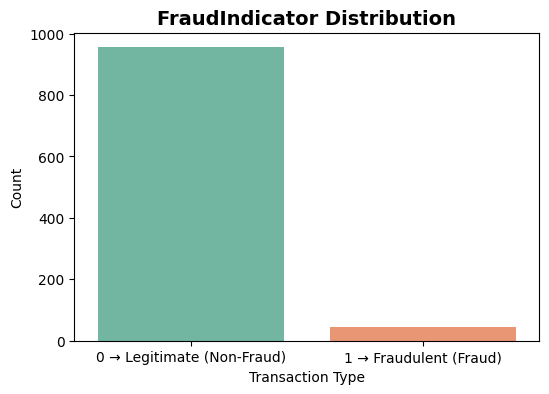

In [15]:
# Target distribution with meaningful ticks
plt.figure(figsize=(6,4))
ax = sns.countplot(x="FraudIndicator", data=data, palette="Set2")

# Set custom tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(["0 → Legitimate (Non-Fraud)", "1 → Fraudulent (Fraud)"])

plt.title("FraudIndicator Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()


In [16]:
# numeric / categorical split
numerical_features = data.select_dtypes(include=["number"]).columns.tolist()
categorical_features = data.select_dtypes(include=["object"]).columns.tolist()
print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['TransactionID', 'FraudIndicator', 'TransactionAmount', 'AnomalyScore', 'MerchantID', 'Amount', 'CustomerID', 'Age', 'AccountBalance', 'SuspiciousFlag']
Categorical features: ['Category', 'Timestamp', 'Name', 'Address', 'LastLogin']


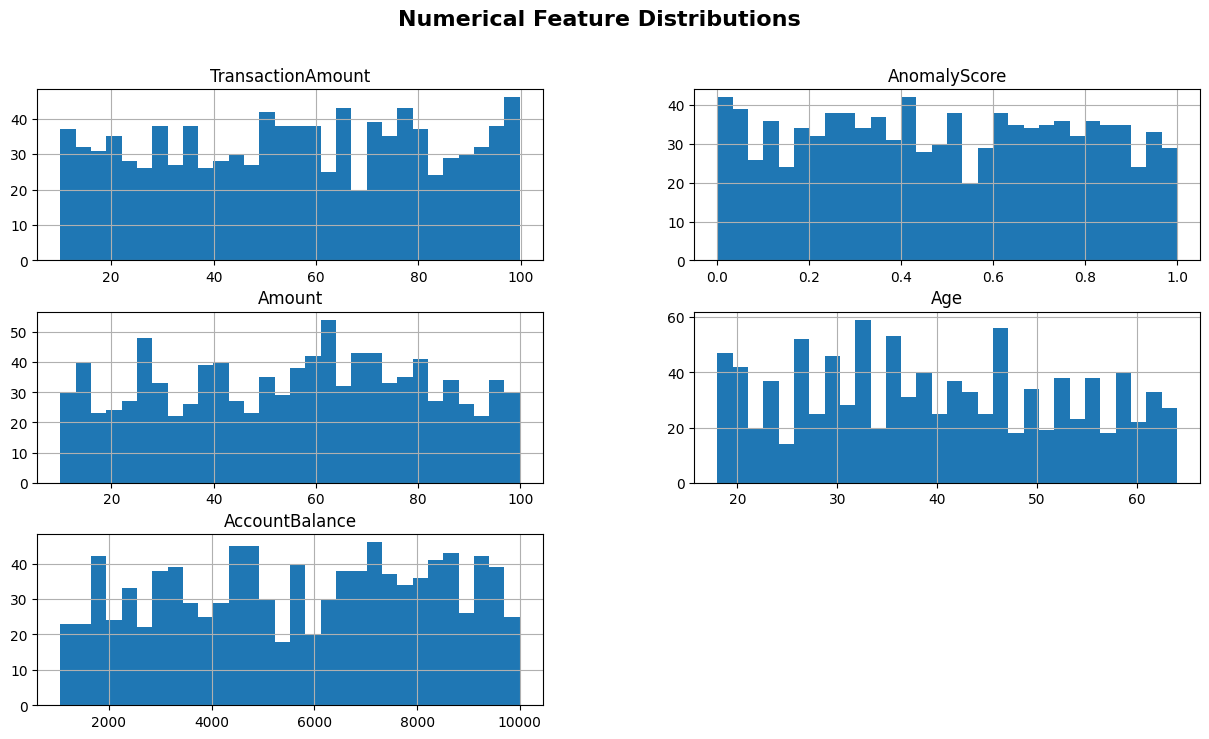

In [17]:
# Histograms for numerical features
num_cols = ['TransactionAmount', 'AnomalyScore', 'Amount', 'Age', 'AccountBalance']
data[num_cols].hist(bins=30, figsize=(15,8))
plt.suptitle("Numerical Feature Distributions", fontsize=16, fontweight="bold")
plt.show()

2025-09-16 23:56:37,131 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\btirk\AppData\Local\Temp\ipykernel_6108\3957645407.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="FraudIndicator", y=col, data=data, palette="Set2")
2025-09-16 23:56:37,142 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-16 23:56:37,188 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\btirk

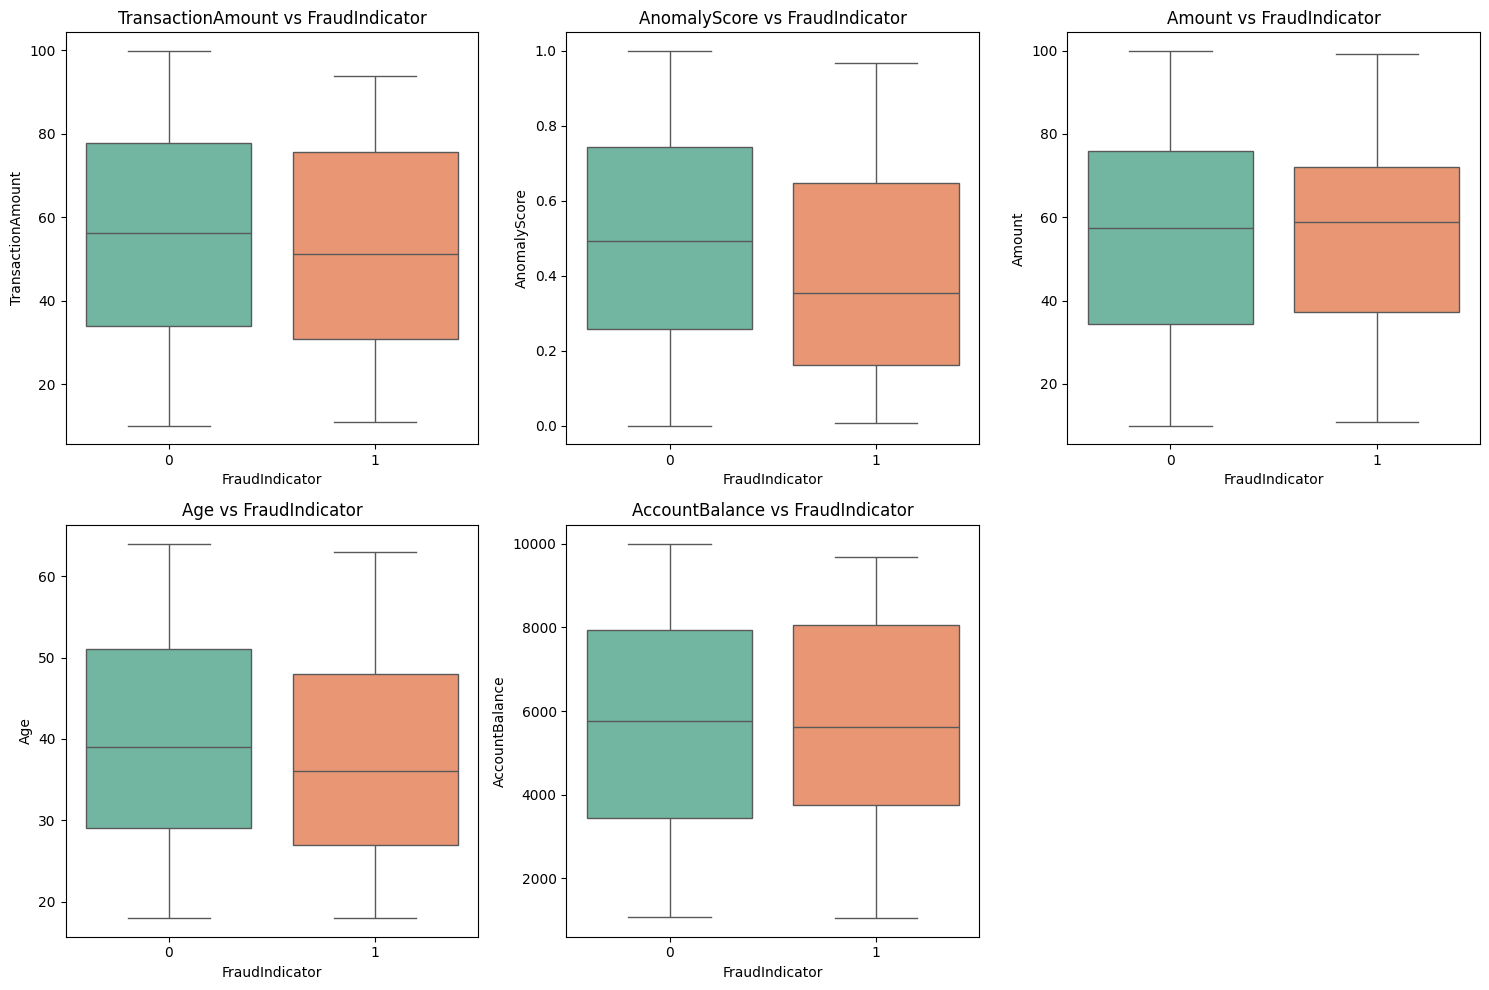

In [18]:
# Boxplots for fraud vs non-fraud
plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="FraudIndicator", y=col, data=data, palette="Set2")
    plt.title(f"{col} vs FraudIndicator")
plt.tight_layout()
plt.show()

C:\Users\btirk\AppData\Local\Temp\ipykernel_6108\4168932719.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Category", data=data, order=data["Category"].value_counts().index, palette="Set2")


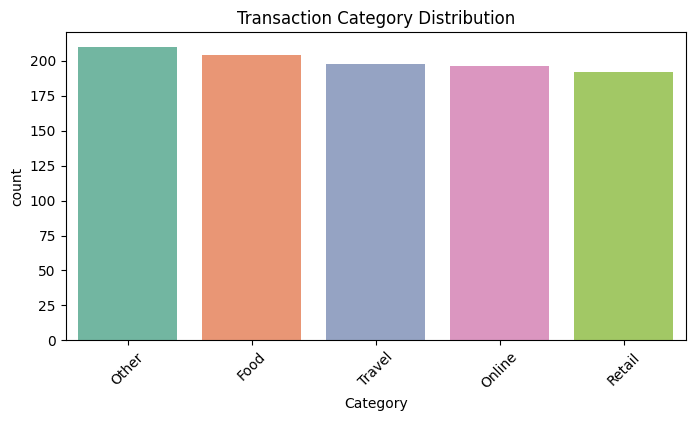

In [19]:
# Category distribution
plt.figure(figsize=(8,4))
sns.countplot(x="Category", data=data, order=data["Category"].value_counts().index, palette="Set2")
plt.title("Transaction Category Distribution")
plt.xticks(rotation=45)
plt.show()

C:\Users\btirk\AppData\Local\Temp\ipykernel_6108\2454363857.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_cat.index, y=fraud_by_cat.values, palette="coolwarm")


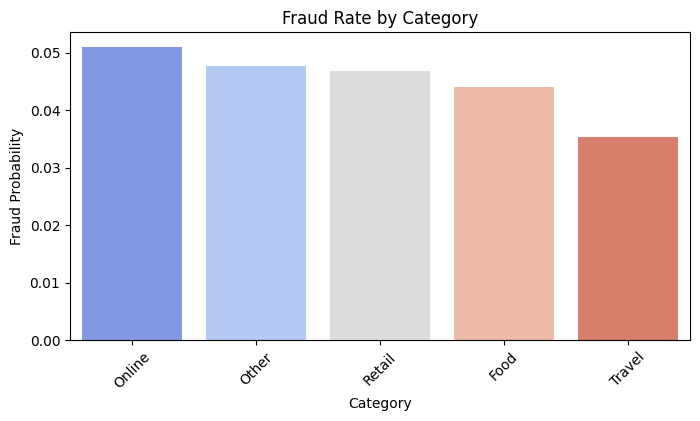

In [20]:
# Fraud rate by Category
fraud_by_cat = data.groupby("Category")["FraudIndicator"].mean().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=fraud_by_cat.index, y=fraud_by_cat.values, palette="coolwarm")
plt.title("Fraud Rate by Category")
plt.ylabel("Fraud Probability")
plt.xticks(rotation=45)
plt.show()

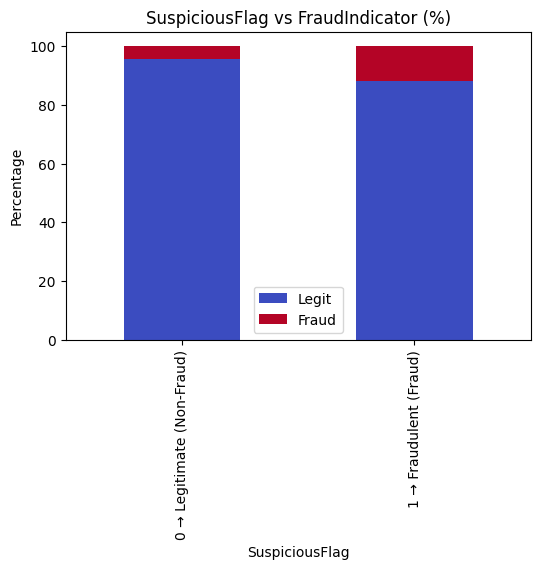

In [21]:
# SuspiciousFlag vs FraudIndicator
ct = pd.crosstab(data["SuspiciousFlag"], data["FraudIndicator"], normalize="index") * 100

# Plot and capture axis
ax = ct.plot(kind="bar", stacked=True, figsize=(6,4), colormap="coolwarm")

# Set custom tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(["0 → Legitimate (Non-Fraud)", "1 → Fraudulent (Fraud)"])

plt.title("SuspiciousFlag vs FraudIndicator (%)")
plt.ylabel("Percentage")
plt.legend(["Legit", "Fraud"])
plt.show()

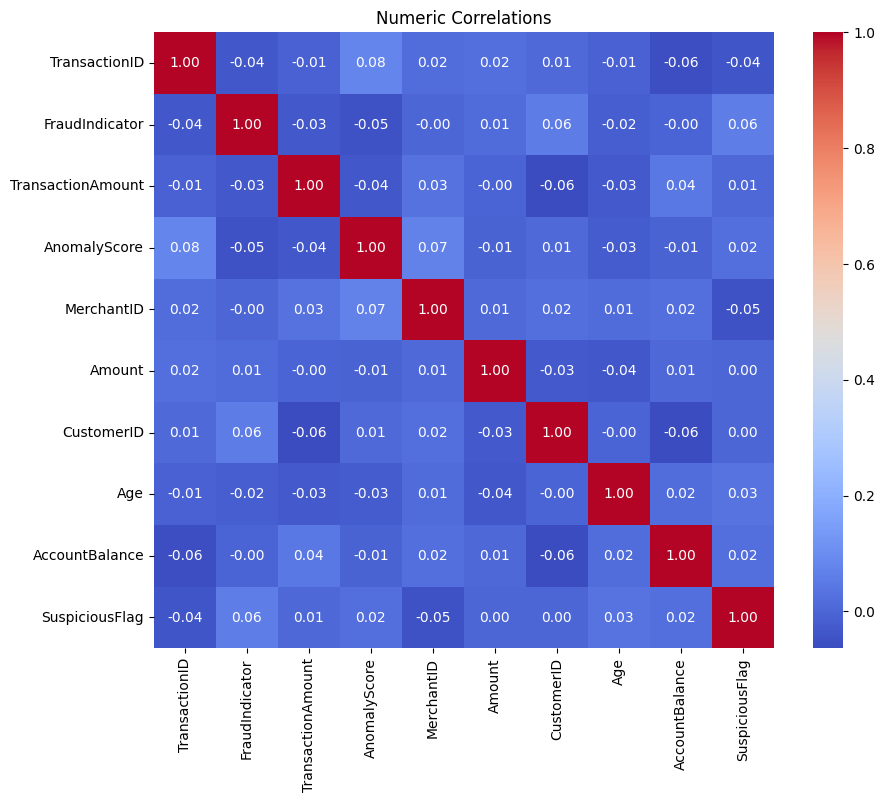

In [22]:
# Correlation heatmap for numeric
plt.figure(figsize=(10,8))
sns.heatmap(data[numerical_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Numeric Correlations")
plt.show()

In [23]:
# Drop identifiers and verbose text (keep only columns helpful for modeling)
drop_cols = ["TransactionID", "MerchantID", "CustomerID", "Name", "Address", "LastLogin"]  # last login used later after converting to datetime
for c in drop_cols:
    if c not in data.columns:
        logging.warning(f"{c} not in data; skipping drop.")

In [24]:
# Keep needed columns, create copy
df = data.copy()

In [25]:
# Convert timestamps
df["Timestamp1"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df["LastLogin_dt"] = pd.to_datetime(df["LastLogin"], errors="coerce")

In [26]:
# Hour and gap features
df["Hour"] = df["Timestamp1"].dt.hour.fillna(-1).astype(int)
df["gap"] = (df["Timestamp1"] - df["LastLogin_dt"]).dt.days.abs()
df["gap"] = df["gap"].fillna(df["gap"].median())

2025-09-16 23:56:38,932 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-16 23:56:38,946 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


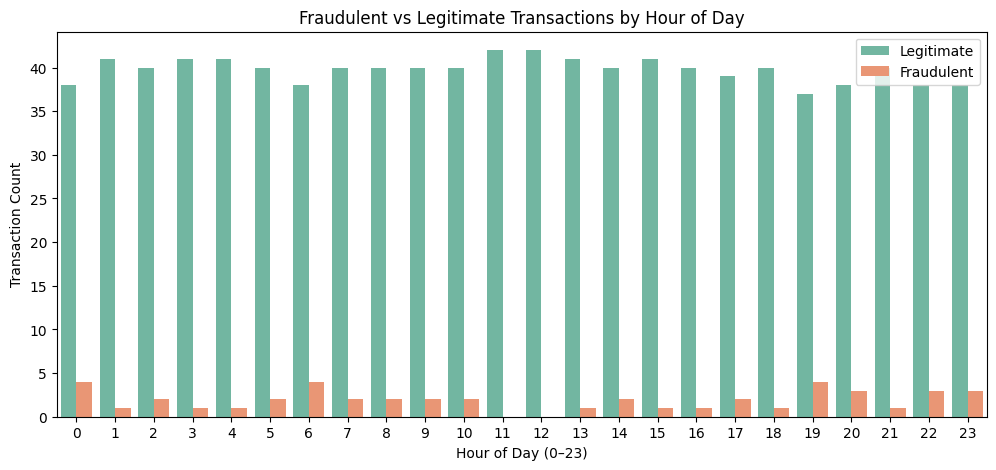

In [27]:
# Fraud vs Legit transactions by hour
plt.figure(figsize=(12,5))
sns.countplot(x="Hour", hue="FraudIndicator", data=df, palette="Set2")
plt.title("Fraudulent vs Legitimate Transactions by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Transaction Count")
plt.legend(["Legitimate", "Fraudulent"])
plt.show()

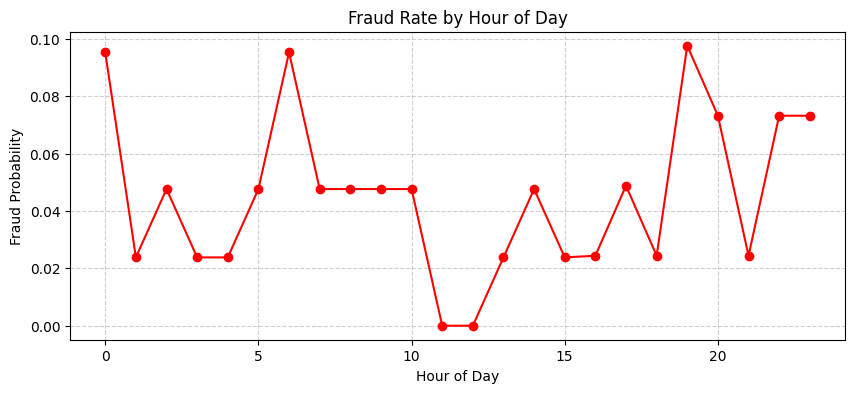

In [28]:
# Fraud rate per hour
fraud_by_hour = df.groupby("Hour")["FraudIndicator"].mean()
plt.figure(figsize=(10,4))
fraud_by_hour.plot(marker="o", color="red")
plt.title("Fraud Rate by Hour of Day")
plt.ylabel("Fraud Probability")
plt.xlabel("Hour of Day")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

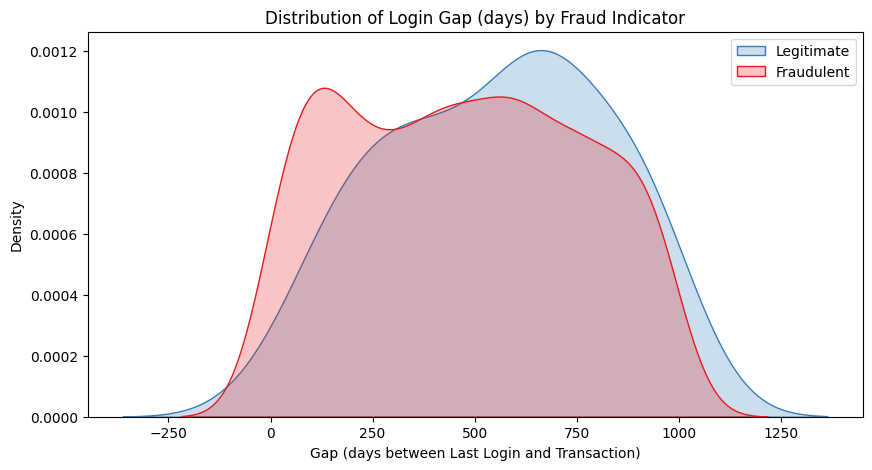

In [29]:
# Distribution of gap for fraud vs legit
plt.figure(figsize=(10,5))
sns.kdeplot(x="gap", hue="FraudIndicator", data=df, fill=True, common_norm=False, palette="Set1")
plt.title("Distribution of Login Gap (days) by Fraud Indicator")
plt.xlabel("Gap (days between Last Login and Transaction)")
plt.ylabel("Density")
plt.legend(["Legitimate", "Fraudulent"])
plt.show()

2025-09-16 23:56:39,618 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\btirk\AppData\Local\Temp\ipykernel_6108\2665772250.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="FraudIndicator", y="gap", data=df, palette="Set2")
2025-09-16 23:56:39,630 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


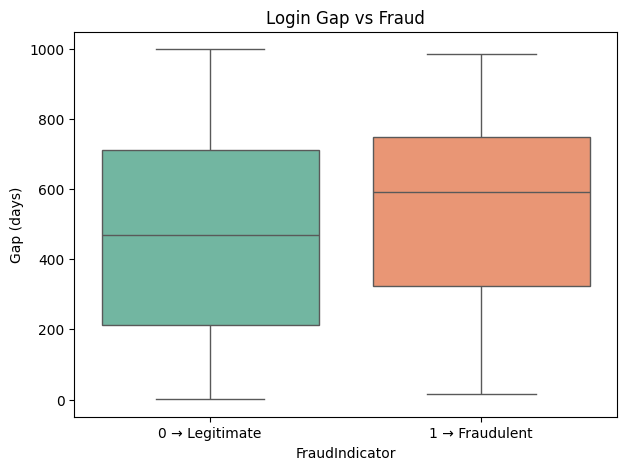

,count,mean,std,min,25%,50%,75%,max
FraudIndicator,,,,,,,,
0,955.0,472.335079,288.840621,1.0,211.5,470.0,711.5,998.0
1,45.0,551.111111,270.494095,17.0,324.0,591.0,749.0,985.0


In [30]:
# Boxplot comparison
plt.figure(figsize=(7,5))
sns.boxplot(x="FraudIndicator", y="gap", data=df, palette="Set2")
plt.title("Login Gap vs Fraud")
plt.xticks([0,1], ["0 → Legitimate", "1 → Fraudulent"])
plt.ylabel("Gap (days)")
plt.show()

# Summary stats
gap_summary = df.groupby("FraudIndicator")["gap"].describe()
display(gap_summary)

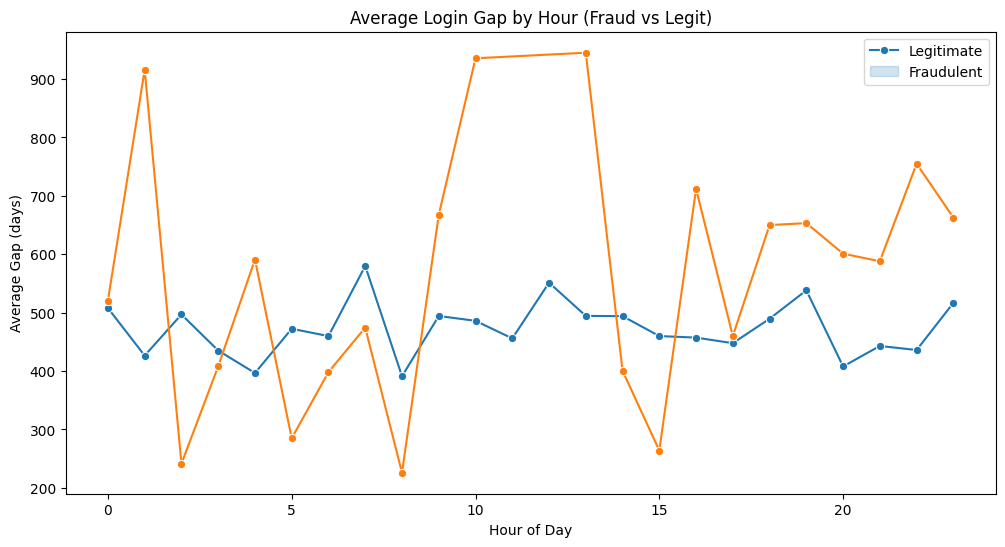

In [31]:
# Average gap by hour and fraud
avg_gap = df.groupby(["Hour","FraudIndicator"])["gap"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x="Hour", y="gap", hue="FraudIndicator", data=avg_gap, marker="o")
plt.title("Average Login Gap by Hour (Fraud vs Legit)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Gap (days)")
plt.legend(["Legitimate", "Fraudulent"])
plt.show()


Insight

Fraud Timing: More fraud occurs at night (0–1 hrs) and evening (18–23 hrs).

Login Gap: Fraudulent accounts tend to have longer and more irregular inactivity gaps than legitimate users.

Detection Strategy: Monitoring login gaps and transaction timing could improve fraud detection. Accounts transacting after unusually long inactivity, especially late-night, should be flagged for higher scrutiny.

In [32]:
# Simplify target and feature set
model_df = df.drop(columns=[c for c in drop_cols if c in df.columns] + ["Timestamp", "Timestamp1", "LastLogin", "LastLogin_dt"])

In [33]:
# Fill missing numericals with median
for col in model_df.select_dtypes(include=["number"]).columns:
    model_df[col] = model_df[col].fillna(model_df[col].median())

In [34]:
# Encode Category using LabelEncoder 
le = LabelEncoder()
if "Category" in model_df.columns:
    model_df["Category"] = model_df["Category"].fillna("Unknown")
    model_df["Category_enc"] = le.fit_transform(model_df["Category"])
    model_df = model_df.drop(columns=["Category"])
else:
    logging.warning("Category column not found")

display(model_df.head())

,FraudIndicator,TransactionAmount,AnomalyScore,Amount,Age,AccountBalance,SuspiciousFlag,Hour,gap,Category_enc
0,0,79.413607,0.686699,55.530334,50,2869.689912,0,0,951,2
1,0,12.053087,0.081749,12.881180,46,9527.947107,0,1,26,1
2,0,33.310357,0.023857,50.176322,34,9288.355525,0,2,954,4
3,0,46.121117,0.876994,41.634001,33,5588.049942,0,3,795,4
4,0,54.051618,0.034059,78.122853,18,7324.785332,0,4,945,2


In [35]:

# Prepare X, y
if "FraudIndicator" not in model_df.columns:
    raise ValueError("FraudIndicator (target) not present in data")

X = model_df.drop(columns=["FraudIndicator"])
y = model_df["FraudIndicator"]

In [36]:
# Final numeric-only feature matrix (we already encoded Category->Category_enc)
X = X.select_dtypes(include=[np.number]).copy()
logging.info(f"Final X shape: {X.shape}, y shape: {y.shape}")

2025-09-16 23:56:40,030 - INFO - Final X shape: (1000, 9), y shape: (1000,)


In [51]:
X.head()

,TransactionAmount,AnomalyScore,Amount,Age,AccountBalance,SuspiciousFlag,Hour,gap,Category_enc
0,79.413607,0.686699,55.530334,50,2869.689912,0,0,951,2
1,12.053087,0.081749,12.881180,46,9527.947107,0,1,26,1
2,33.310357,0.023857,50.176322,34,9288.355525,0,2,954,4
3,46.121117,0.876994,41.634001,33,5588.049942,0,3,795,4
4,54.051618,0.034059,78.122853,18,7324.785332,0,4,945,2


In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionAmount  1000 non-null   float64
 1   AnomalyScore       1000 non-null   float64
 2   Amount             1000 non-null   float64
 3   Age                1000 non-null   int64  
 4   AccountBalance     1000 non-null   float64
 5   SuspiciousFlag     1000 non-null   int64  
 6   Hour               1000 non-null   int32  
 7   gap                1000 non-null   int64  
 8   Category_enc       1000 non-null   int32  
dtypes: float64(4), int32(2), int64(3)
memory usage: 62.6 KB


In [52]:
X.columns

Index(['TransactionAmount', 'AnomalyScore', 'Amount', 'Age', 'AccountBalance',
       'SuspiciousFlag', 'Hour', 'gap', 'Category_enc'],
      dtype='object')

In [49]:
y.sample(5)

349    0
528    0
833    0
782    0
939    0
Name: FraudIndicator, dtype: int64

In [45]:
y.value_counts()

FraudIndicator
0    955
1     45
Name: count, dtype: int64

In [37]:
# Train-test split (do this BEFORE SMOTE)
# Stratify to maintain class balance to split traget column equally in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)
logging.info(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

2025-09-16 23:56:40,068 - INFO - Train shape: (800, 9), Test shape: (200, 9)


In [38]:
# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
# SMOTE  to handle imbalance

smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
logging.info(f"After SMOTE -> X_train_smote: {X_train_smote.shape},\n y_train_smote distribution:\n{pd.Series(y_train_smote).value_counts()}")

2025-09-17 00:05:10,607 - INFO - After SMOTE -> X_train_smote: (1528, 9),
 y_train_smote distribution:
FraudIndicator
0    764
1    764
Name: count, dtype: int64


In [40]:
# Function: train & evaluate a model and log to MLflow
# --------------------------
def evaluate_and_log(model, model_name, params=None):
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model", model_name)
        if params:
            for k, v in params.items():
                mlflow.log_param(k, v)
        # fit
        model.fit(X_train_smote, y_train_smote)
        # predict on test (unseen original test set)
        y_pred = model.predict(X_test_scaled)
        # metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)
        # log metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        # save model artifact
        mlflow.sklearn.log_model(model, artifact_path=f"{model_name}_model")
        # log confusion matrix as text artifact
        mlflow.log_text(str(cm), artifact_file="confusion_matrix.txt")
        # Print
        logging.info(f"{model_name} -> acc:{acc:.4f}, prec:{prec:.4f}, rec:{rec:.4f}, f1:{f1:.4f}")
        display(pd.DataFrame({
            "metric": ["accuracy", "precision", "recall", "f1"],
            "value": [acc, prec, rec, f1]
        }))
        print("Classification report:")
        print(classification_report(y_test, y_pred, zero_division=0))
        return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "cm": cm}

In [41]:
# Train multiple baseline models and track with MLflow
# --------------------------
models = {
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=RANDOM_STATE, probability=True)
}

results = {}
for name, model in models.items():
    results[name] = evaluate_and_log(model, name)

# --------------------------
# Hyperparameter tuning for RandomForest (example), track best
# --------------------------
rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
grid = GridSearchCV(rf, rf_param_grid, cv=3, scoring="f1", n_jobs=-1)
grid.fit(X_train_smote, y_train_smote)

best_rf = grid.best_estimator_
logging.info(f"RandomForest best params: {grid.best_params_}")
# Log best RF separately
rf_metrics = evaluate_and_log(best_rf, "RandomForest_Tuned", params=grid.best_params_)

2025/09/16 23:56:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-09-16 23:56:51,719 - INFO - RandomForest -> acc:0.9300, prec:0.0000, rec:0.0000, f1:0.0000


,metric,value
0,accuracy,0.93
1,precision,0.00
2,recall,0.00
3,f1,0.00


Classification report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       191
           1       0.00      0.00      0.00         9

    accuracy                           0.93       200
   macro avg       0.48      0.49      0.48       200
weighted avg       0.91      0.93      0.92       200



2025/09/16 23:56:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-09-16 23:56:55,713 - INFO - GradientBoosting -> acc:0.9150, prec:0.0000, rec:0.0000, f1:0.0000


,metric,value
0,accuracy,0.915
1,precision,0.000
2,recall,0.000
3,f1,0.000


Classification report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       191
           1       0.00      0.00      0.00         9

    accuracy                           0.92       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.91      0.92      0.91       200



2025/09/16 23:56:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-09-16 23:56:59,175 - INFO - DecisionTree -> acc:0.8850, prec:0.0000, rec:0.0000, f1:0.0000


,metric,value
0,accuracy,0.885
1,precision,0.000
2,recall,0.000
3,f1,0.000


Classification report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       191
           1       0.00      0.00      0.00         9

    accuracy                           0.89       200
   macro avg       0.48      0.46      0.47       200
weighted avg       0.91      0.89      0.90       200



2025/09/16 23:57:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-09-16 23:57:02,689 - INFO - KNN -> acc:0.7450, prec:0.0625, rec:0.3333, f1:0.1053


,metric,value
0,accuracy,0.745000
1,precision,0.062500
2,recall,0.333333
3,f1,0.105263


Classification report:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       191
           1       0.06      0.33      0.11         9

    accuracy                           0.74       200
   macro avg       0.51      0.55      0.48       200
weighted avg       0.92      0.74      0.82       200



2025/09/16 23:57:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-09-16 23:57:06,189 - INFO - SVM -> acc:0.8350, prec:0.0385, rec:0.1111, f1:0.0571


,metric,value
0,accuracy,0.835000
1,precision,0.038462
2,recall,0.111111
3,f1,0.057143


Classification report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       191
           1       0.04      0.11      0.06         9

    accuracy                           0.83       200
   macro avg       0.50      0.49      0.48       200
weighted avg       0.91      0.83      0.87       200



2025-09-16 23:57:12,917 - INFO - RandomForest best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
2025/09/16 23:57:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-09-16 23:57:18,515 - INFO - RandomForest_Tuned -> acc:0.9300, prec:0.0000, rec:0.0000, f1:0.0000


,metric,value
0,accuracy,0.93
1,precision,0.00
2,recall,0.00
3,f1,0.00


Classification report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       191
           1       0.00      0.00      0.00         9

    accuracy                           0.93       200
   macro avg       0.48      0.49      0.48       200
weighted avg       0.91      0.93      0.92       200



In [42]:
# --------------------------
# Summary table of results
# --------------------------
summary = []
for model_name, vals in results.items():
    summary.append({
        "model": model_name,
        "accuracy": vals["accuracy"],
        "precision": vals["precision"],
        "recall": vals["recall"],
        "f1": vals["f1"]
    })
# add tuned RF
summary.append({
    "model": "RandomForest_Tuned",
    "accuracy": rf_metrics["accuracy"],
    "precision": rf_metrics["precision"],
    "recall": rf_metrics["recall"],
    "f1": rf_metrics["f1"]
})

summary_df = pd.DataFrame(summary).sort_values(by="f1", ascending=False)
display(summary_df)

# Save summary to mlflow artifact as csv
with mlflow.start_run(run_name="summary_save"):
    summary_csv = "model_summary.csv"
    summary_df.to_csv(summary_csv, index=False)
    mlflow.log_artifact(summary_csv)
    logging.info(f"Saved model summary and logged to MLflow as {summary_csv}")


,model,accuracy,precision,recall,f1
3,KNN,0.745,0.062500,0.333333,0.105263
4,SVM,0.835,0.038462,0.111111,0.057143
0,RandomForest,0.930,0.000000,0.000000,0.000000
1,GradientBoosting,0.915,0.000000,0.000000,0.000000
2,DecisionTree,0.885,0.000000,0.000000,0.000000
5,RandomForest_Tuned,0.930,0.000000,0.000000,0.000000


2025-09-16 23:57:18,633 - INFO - Saved model summary and logged to MLflow as model_summary.csv
